# Siamese CNN training for speaker verification

## Imports and constants

In [1]:
import os
import glob

import torch
import torchaudio
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timm
import gc

from torchaudio.datasets import VoxCeleb1Verification
from tqdm import tqdm
from torch import nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display, Audio
import torch.nn.functional as F
from torch.cuda import empty_cache
from torchvision.transforms import Compose

/home/ashevtsov/speaker-verification-project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_SAVE_PATH = './models/efficientnet_1.0.9_augm.pt'
MODEL_HEAD_SAVE_PATH = './models/head_efficientnet_1.0.9_augm.pt'

EMBEDDING_DIM = 256
MAX_LENGTH = 240_000
POS_WEIGHT = 4.0
TRIPLET_LOSS_FRAC = 0.3

BATCH_SIZE = 32
CLASS_BATCH_SIZE = 6
EPOCHS = 2
EVAL_EVERY_STEPS = 150

DEVICE = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

## Data preparation

In [3]:
test_dataset = VoxCeleb1Verification('../data', download=False)

### Data split

We need to split data in the clever way, leaving some speakers for validation, and not using them as well as some speakers from pre-defined test.

In [4]:
# occs = dict()
# for _, _, _, _, f1, f2 in tqdm(test_dataset):
#     id1 = f1.split('-')[0]
#     id2 = f2.split('-')[0]
#     if id1 not in occs:
#         occs[id1] = 0
#     if id2 not in occs:
#         occs[id2] = 0
#     occs[id1] += 1
#     occs[id2] += 1

Speakers who are used in test:

In [5]:
# len(occs.keys())

In [6]:
# test_ids = sorted(list(occs.keys()))

Extracting validation speakers:

In [7]:
# val_ids = np.random.choice(list(set(os.listdir('../data/wav/')) - set(test_ids)), size=40, replace=False)
# val_ids  = sorted(list(val_ids))
# len(set(os.listdir('../data/wav/')) - set(test_ids) - set(val_ids))

Saving all the test and validation speakers to be reused throughout the project:

In [8]:
# with open('../data/test_ids.txt', 'w') as f:
#     f.write(str(test_ids))

# with open('../data/val_ids.txt', 'w') as f:
#     f.write(str(val_ids))

### Data split load

In [9]:
with open('../data/test_ids.txt', 'r') as f:
    test_ids = eval(f.read())

with open('../data/val_ids.txt', 'r') as f:
    val_ids = eval(f.read())

In [10]:
samples_files = glob.glob('../data/wav/**/**/*.wav')
samples_df = pd.DataFrame({'path': samples_files})
samples_df['path'] = samples_df['path'].str.replace('\\', '/')
samples_df['speaker_id'] = samples_df['path'].apply(lambda path: path.split('/')[-3])
samples_df['utterance_id'] = samples_df['path'].apply(lambda path: path.split('/')[-2])
samples_df['sample_id'] = samples_df['path'].apply(lambda path: path.split('/')[-1])

In [11]:
samples_df

,path,speaker_id,utterance_id,sample_id
0,../data/wav/id11024/LT16_SZUEUA/00001.wav,id11024,LT16_SZUEUA,00001.wav
1,../data/wav/id11024/LT16_SZUEUA/00011.wav,id11024,LT16_SZUEUA,00011.wav
2,../data/wav/id11024/LT16_SZUEUA/00008.wav,id11024,LT16_SZUEUA,00008.wav
3,../data/wav/id11024/LT16_SZUEUA/00007.wav,id11024,LT16_SZUEUA,00007.wav
4,../data/wav/id11024/LT16_SZUEUA/00010.wav,id11024,LT16_SZUEUA,00010.wav
...,...,...,...,...
153511,../data/wav/id11098/iQfAj3ayKVU/00002.wav,id11098,iQfAj3ayKVU,00002.wav
153512,../data/wav/id11098/78EDYQcqXDo/00001.wav,id11098,78EDYQcqXDo,00001.wav
153513,../data/wav/id11098/78EDYQcqXDo/00003.wav,id11098,78EDYQcqXDo,00003.wav
153514,../data/wav/id11098/78EDYQcqXDo/00002.wav,id11098,78EDYQcqXDo,00002.wav


In [12]:
train_df = samples_df.loc[~samples_df['speaker_id'].isin(test_ids) & ~samples_df['speaker_id'].isin(val_ids)]
test_df = samples_df.loc[samples_df['speaker_id'].isin(test_ids)]
val_df = samples_df.loc[samples_df['speaker_id'].isin(val_ids)]

Sanity check:

In [13]:
# for filepath in tqdm(samples_df['path']):
#     _, sr = torchaudio.load(filepath)
#     assert sr == 16000, sr

In [14]:
# audio_lengths = []
# for filepath in tqdm(samples_df['path'][:2000]):
#     audio, _ = torchaudio.load(filepath)
#     audio_lengths.append(audio.size()[1])

Saving in HDF5 format (created with ChatGPT):

In [15]:
# HDF5_FILE = "../data/dataset.hdf5"

In [16]:
# # Initialize HDF5 file
# with h5py.File(HDF5_FILE, "w") as hf:
#     # Iterate over speaker folders
#     for speaker_id in tqdm(os.listdir('..\\data\\wav\\'), desc='Speakers'):
#         speaker_group = hf.create_group(speaker_id)
#         speaker_path = os.path.join('..\\data\\wav\\', speaker_id)
#         # Iterate over utterance folders
#         for utterance_id in os.listdir(speaker_path):
#             utterance_group = speaker_group.create_group(utterance_id)
#             utterance_path = os.path.join(speaker_path, utterance_id)
#             # Iterate over sample files
#             for sample_id in os.listdir(utterance_path):
#                 sample_path = os.path.join(utterance_path, sample_id)
#                 if not os.path.isfile(sample_path):
#                     continue
#                 # Read the sample data
#                 data, sr = torchaudio.load(sample_path)
#                 # Create a dataset in the HDF5 file and write the sample data
#                 utterance_group.create_dataset(sample_id, data=data, compression="gzip")

In [17]:
# def load_sample(speaker_id, utterance_id, sample_id):
#     with h5py.File(HDF5_FILE, "r") as hf:
#         try:
#             sample_data = hf[speaker_id][utterance_id][sample_id][:]
#             return torch.tensor(sample_data)
#         except KeyError:
#             print("Sample not found.")
#             return None

Dataset for training:

In [18]:
# class VoxCeleb1Triplet(torch.utils.data.Dataset):
#     def __init__(self, train_df: pd.DataFrame, transforms = None, max_length: int = MAX_LENGTH):
#         self.df = train_df
#         self.transforms = transforms
#         self.max_length = max_length
    
#     def __len__(self):
#         return len(self.df)
    
#     def _crop_or_extend(self, sample):
#         if sample.size()[1] > self.max_length:
#             sample = sample[:, :self.max_length]
#         else:
#             sample = torch.cat((sample, torch.zeros((1, self.max_length - sample.size()[1]))), dim=1)
#         return sample

#     def __getitem__(self, id):
#         selected_row = self.df.iloc[id]
#         selected_speaker_id = selected_row['speaker_id']

#         positive_row = self.df.loc[(self.df['speaker_id'] == selected_speaker_id) & (self.df.index != id)].sample(1).iloc[0]

#         assert positive_row is not None, f"There are now samples for the same speaker {selected_speaker_id}, row {id}"

#         negative_row = self.df.loc[(self.df['speaker_id'] != selected_speaker_id)].sample(1).iloc[0]

#         assert negative_row is not None, f"There are no negative samples"

#         anchor_audio, anchor_sr = torchaudio.load(selected_row['path'])
#         pos_audio, pos_sr = torchaudio.load(positive_row['path'])
#         neg_audio, neg_sr = torchaudio.load(negative_row['path'])
#         assert anchor_sr == 16000 and pos_sr == 16000 and neg_sr == 16000
#         # anchor_audio = load_sample(selected_row['speaker_id'], selected_row['utterance_id'], selected_row['sample_id'])
#         # pos_audio = load_sample(positive_row['speaker_id'], positive_row['utterance_id'], positive_row['sample_id'])
#         # neg_audio = load_sample(negative_row['speaker_id'], negative_row['utterance_id'], negative_row['sample_id'])

#         if self.transforms is not None:
#             anchor_audio = self.transforms(anchor_audio)
#             pos_audio = self.transforms(pos_audio)
#             neg_audio = self.transforms(neg_audio)
        
#         anchor_audio = self._crop_or_extend(anchor_audio)
#         pos_audio = self._crop_or_extend(pos_audio)
#         neg_audio = self._crop_or_extend(neg_audio)
        
#         return anchor_audio, pos_audio, neg_audio

In [19]:
# train_dataset = VoxCeleb1Triplet(train_df)

In [20]:
def speaker_id_to_int(speaker_id: str):
    return int(speaker_id[3:])

In [21]:
class VoxCeleb1Unary(torch.utils.data.Dataset):
    def __init__(self, train_df: pd.DataFrame, transforms = None, max_length: int = MAX_LENGTH, supporting_count: int = CLASS_BATCH_SIZE - 1):
        self.df = train_df
        self.transforms = transforms
        self.max_length = max_length
        self.supporting_count = max(supporting_count, 0)
    
    def __len__(self):
        return len(self.df)
    
    def _crop_or_extend(self, sample):
        if sample.size()[1] > self.max_length:
            sample = sample[:, :self.max_length]
        else:
            sample = torch.cat((sample, torch.zeros((1, self.max_length - sample.size(1)))), dim=1)
        return sample

    def __getitem__(self, id):
        selected_row = self.df.iloc[id]
        selected_speaker_id = selected_row['speaker_id']
        positive_rows = self.df.loc[(self.df['speaker_id'] == selected_speaker_id) & (self.df.index != id)] \
            .sample(self.supporting_count)

        audio, sr = torchaudio.load(selected_row['path'])
        assert sr == 16000
        audios = [audio]
        for i in range(self.supporting_count):
            audio, sr = torchaudio.load(positive_rows.iloc[i]['path'])
            assert sr == 16000
            audios.append(audio)
        # audio = load_sample(selected_row['speaker_id'], selected_row['utterance_id'], selected_row['sample_id'])

        if self.transforms is not None:
            for i in range(self.supporting_count + 1):
                audios[i] = self.transforms(audios[i])
        
        for i in range(self.supporting_count + 1):
            audios[i] = self._crop_or_extend(audios[i])
        
        return torch.cat(audios), torch.ones(self.supporting_count + 1) * speaker_id_to_int(selected_speaker_id)

Transforms defined:

In [22]:
class ToComplexTensor(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def forward(self, real_tensor):
        return real_tensor.type(torch.complex64)

In [23]:
class RandomTimeStretch(torchaudio.transforms.TimeStretch):
    def __init__(self, max_size: int, hop_length: int | None = None, n_freq: int = 128, min_rate: float | None = None, max_rate: float | None = None) -> None:
        super().__init__(hop_length, n_freq, None)
        self.n_freq = n_freq
        self.max_size = max_size
        self.min_rate = torch.tensor(min_rate if min_rate is not None and min_rate > 0 else 0.5)
        self.max_rate = torch.tensor(max_rate if max_rate is not None else 2)
    
    def _crop_or_extend(self, sample):
        if sample.size()[2] > self.max_size:
            sample = sample[:, :self.max_size]
        else:
            sample = torch.cat((sample, torch.zeros((1, self.n_freq, self.max_size - sample.size(2)), device=sample.device)), dim=2)
        return sample

    def forward(self, complex_specgrams: torch.Tensor):
        results = []
        for i in range(complex_specgrams.size(0)):
            new_size = torch.empty(1).uniform_(self.min_rate, self.max_rate)
            results.append(self._crop_or_extend(super().forward(complex_specgrams[i], 
                                float(new_size))))

        gc.collect()
        empty_cache()

        return torch.cat(results)

In [24]:
train_dataset = VoxCeleb1Unary(train_df)

# transforms=Compose([
#     # torchaudio.transforms.MelSpectrogram(n_mels=201),
#     # torchaudio.transforms.TimeMasking(time_mask_param=40, p=0.8),
#     # torchaudio.transforms.FrequencyMasking(freq_mask_param=200),
#     # ToComplexTensor(),
#     # RandomTimeStretch(),
#     # torchaudio.transforms.InverseSpectrogram(),
# ])

In [25]:
train_dataset[0]

(tensor([[ 0.0007, -0.0011, -0.0017,  ...,  0.0286,  0.0200,  0.0184],
         [-0.0002,  0.0171, -0.0038,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0203, -0.0211, -0.0202,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0011, -0.0012, -0.0012,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0118, -0.0038, -0.0183,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0015,  0.0011,  0.0010,  ...,  0.0000,  0.0000,  0.0000]]),
 tensor([1024., 1024., 1024., 1024., 1024., 1024.]))

Validation dataset:

In [26]:
class VoxCeleb1Validation(torch.utils.data.Dataset):
    def __init__(self, val_df: pd.DataFrame, transforms = None, max_length: int = MAX_LENGTH):
        self.df = val_df
        self.transforms = transforms
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    
    def _crop_or_extend(self, sample):
        if sample.size()[1] > self.max_length:
            sample = sample[:, :self.max_length]
        else:
            sample = torch.cat((sample, torch.zeros((1, self.max_length - sample.size()[1]))), dim=1)
        return sample

    def __getitem__(self, id):
        selected_row = self.df.iloc[id]
        selected_speaker_id = selected_row['speaker_id']

        res_class = np.random.choice((0, 1))

        if res_class == 1:
            rel_row = self.df.loc[(self.df['speaker_id'] == selected_speaker_id) & (self.df.index != id)].sample(1).iloc[0]
        else:
            rel_row = self.df.loc[(self.df['speaker_id'] != selected_speaker_id)].sample(1).iloc[0]

        assert rel_row is not None, f"There are now samples for the row {id}"

        anchor_audio, anchor_sr = torchaudio.load(selected_row['path'])
        rel_audio, rel_sr = torchaudio.load(rel_row['path'])
        assert anchor_sr == 16000 and rel_sr == 16000
        # anchor_audio = load_sample(selected_row['speaker_id'], selected_row['utterance_id'], selected_row['sample_id'])
        # rel_audio = load_sample(rel_row['speaker_id'], rel_row['utterance_id'], rel_row['sample_id'])

        if self.transforms is not None:
            anchor_audio = self.transforms(anchor_audio)
            rel_audio = self.transforms(rel_audio)
        
        anchor_audio = self._crop_or_extend(anchor_audio)
        rel_audio = self._crop_or_extend(rel_audio)

        return anchor_audio, rel_audio, res_class

In [27]:
val_dataset = VoxCeleb1Validation(val_df)

In [28]:
val_dataset[0]

(tensor([[-9.1553e-05, -2.7466e-04, -1.5259e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]),
 tensor([[-0.0062, -0.0083, -0.0103,  ...,  0.0000,  0.0000,  0.0000]]),
 0)

# Modelling

In [29]:
class SiameseCNN(nn.Module):
    def __init__(self, backbone_name: str, backbone_pretrained: bool, res_dim: int, n_fft: int, hop_size: int, n_mels: int, mapper_dropout_p: float, power: float = 1.0, sr: int = 16000, logmel: bool = False):
        super().__init__()

        self.melspec = nn.Sequential(torchaudio.transforms.Spectrogram(
            n_fft=n_fft,
            hop_length=hop_size,
            power=power,
        ), torchaudio.transforms.MelScale(
            n_mels=n_mels,
            sample_rate=sr,
            n_stft=n_fft // 2 + 1,
            f_min=0,
        ))

        self.augm = nn.Sequential(
            torchaudio.transforms.TimeMasking(time_mask_param=40, p=0.8, iid_masks=True),
            torchaudio.transforms.FrequencyMasking(freq_mask_param=n_mels//5, iid_masks=True),
            # ToComplexTensor(),
            # RandomTimeStretch(max_size = MAX_LENGTH, n_freq=n_mels, hop_length=hop_size),
        )

        self.logmel = logmel

        self.backbone = timm.create_model(
            backbone_name,
            features_only=True,
            pretrained=backbone_pretrained,
            in_chans=1,
            exportable=True
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.mapper = nn.Sequential(
            nn.Dropout(p=mapper_dropout_p),
            nn.Linear(self.backbone.feature_info.channels()[-1], res_dim),
        )


    def forward(self, input, return_specs=False, return_augm=False):
        specs = self.melspec(input)
        if self.logmel:
            specs = torch.log10(torch.clamp(specs, min=torch.tensor(1e-3, device=specs.device)))
        
        if return_specs:
            return specs

        if self.training:
            specs = self.augm(specs)
            specs = specs.type(torch.float32)
        if return_augm:
            return specs

        # emb = self.backbone(input)[-1]
        emb = self.backbone(specs)[-1]

        bs, ch, _, _ = emb.shape
        emb = self.pool(emb)
        emb = emb.view(bs, ch)

        emb = self.mapper(emb)
        return emb


In [30]:
class SiameseHead(nn.Module):
    def __init__(self, input_dim: int, drop_p=0.25):
        super().__init__()

        self.dropout = nn.Dropout(p=drop_p)
        self.layers = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            self.dropout,
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            self.dropout,
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            self.dropout,
            nn.Linear(32, 1)
        )


    def forward(self, input):
        return self.layers(input)


In [31]:
model = SiameseCNN('tf_efficientnet_b0.in1k', True, EMBEDDING_DIM, 1024, 512, 128, 0.25, logmel=True)
# model = SiameseCNN('convnext_tiny.in12k_ft_in1k', True, EMBEDDING_DIM, 1024, 512, 128, 0.25, logmel=True)
model_head = SiameseHead(input_dim=2*EMBEDDING_DIM)

model = model.to(DEVICE)
model_head = model_head.to(DEVICE)

Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Checking that augmentations work:

In [32]:
first_batch = train_dataset[0]

In [33]:
specs_augmented = model(first_batch[0].unsqueeze(1).cuda(1), return_augm=True)
specs_pure = model(first_batch[0].unsqueeze(1).cuda(1), return_specs=True)

In [34]:
# plt.imshow(specs_augmented[0][0].cpu().detach().numpy())
# plt.show()

In [35]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE*CLASS_BATCH_SIZE, shuffle=False)

## Losses definition

In [36]:
class TripletLoss(nn.Module):
    def __init__(self, margin: float = 1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    @staticmethod
    def calc_euclidean(x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = TripletLoss.calc_euclidean(anchor, positive)
        distance_negative = TripletLoss.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

https://towardsdatascience.com/triplet-loss-advanced-intro-49a07b7d8905

In [37]:
class BatchAllTtripletLoss(nn.Module):
    """Uses all valid triplets to compute Triplet loss
    Args:
        margin: Margin value in the Triplet Loss equation
    """
    def __init__(self, margin=1.0, eps=1e-8):
        super().__init__()
        self.margin = margin
        self.eps = eps
        # self.threshold = self.margin*100
    
    def euclidean_distance_matrix(self, x):
        """Efficient computation of Euclidean distance matrix
        Args:
            x: Input tensor of shape (batch_size, embedding_dim)
            
        Returns:
            Distance matrix of shape (batch_size, batch_size)
        """
        # step 1 - compute the dot product

        # shape: (batch_size, batch_size)
        dot_product = torch.mm(x, x.t())

        # step 2 - extract the squared Euclidean norm from the diagonal

        # shape: (batch_size,)
        squared_norm = torch.diag(dot_product)

        # step 3 - compute squared Euclidean distances

        # shape: (batch_size, batch_size)
        distance_matrix = squared_norm.unsqueeze(0) - 2 * dot_product + squared_norm.unsqueeze(1)

        # get rid of negative distances due to numerical instabilities
        distance_matrix = F.relu(distance_matrix)

        # step 4 - compute the non-squared distances
        
        # handle numerical stability
        # derivative of the square root operation applied to 0 is infinite
        # we need to handle by setting any 0 to eps
        mask = (distance_matrix == 0.0).float()

        # use this mask to set indices with a value of 0 to eps
        distance_matrix = distance_matrix + mask * self.eps

        # now it is safe to get the square root
        distance_matrix = torch.sqrt(distance_matrix)

        # undo the trick for numerical stability
        distance_matrix = (1.0 - mask)*distance_matrix

        return distance_matrix

    def get_triplet_mask(self, labels):
        """compute a mask for valid triplets
        Args:
            labels: Batch of integer labels. shape: (batch_size,)
        Returns:
            Mask tensor to indicate which triplets are actually valid. Shape: (batch_size, batch_size, batch_size)
            A triplet is valid if:
            `labels[i] == labels[j] and labels[i] != labels[k]`
            and `i`, `j`, `k` are different.
        """
        # step 1 - get a mask for distinct indices

        # shape: (batch_size, batch_size)
        indices_equal = torch.eye(labels.size()[0], dtype=torch.bool, device=labels.device)
        indices_not_equal = torch.logical_not(indices_equal)
        # shape: (batch_size, batch_size, 1)
        i_not_equal_j = indices_not_equal.unsqueeze(2)
        # shape: (batch_size, 1, batch_size)
        i_not_equal_k = indices_not_equal.unsqueeze(1)
        # shape: (1, batch_size, batch_size)
        j_not_equal_k = indices_not_equal.unsqueeze(0)
        # Shape: (batch_size, batch_size, batch_size)
        distinct_indices = torch.logical_and(torch.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)

        # step 2 - get a mask for valid anchor-positive-negative triplets

        # shape: (batch_size, batch_size)
        labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)
        # shape: (batch_size, batch_size, 1)
        i_equal_j = labels_equal.unsqueeze(2)
        # shape: (batch_size, 1, batch_size)
        i_equal_k = labels_equal.unsqueeze(1)
        # shape: (batch_size, batch_size, batch_size)
        valid_indices = torch.logical_and(i_equal_j, torch.logical_not(i_equal_k))

        # step 3 - combine two masks
        mask = torch.logical_and(distinct_indices, valid_indices)

        return mask
    
    def forward(self, embeddings, labels):
        """computes loss value.
        Args:
        embeddings: Batch of embeddings, e.g., output of the encoder. shape: (batch_size, embedding_dim)
        labels: Batch of integer labels associated with embeddings. shape: (batch_size,)
        Returns:
        Scalar loss value.
        """
        # step 1 - get distance matrix
        # shape: (batch_size, batch_size)
        distance_matrix = self.euclidean_distance_matrix(embeddings)

        # step 2 - compute loss values for all triplets by applying broadcasting to distance matrix

        # shape: (batch_size, batch_size, 1)
        anchor_positive_dists = distance_matrix.unsqueeze(2)
        # shape: (batch_size, 1, batch_size)
        anchor_negative_dists = distance_matrix.unsqueeze(1)
        # get loss values for all possible n^3 triplets
        # shape: (batch_size, batch_size, batch_size)
        triplet_loss = anchor_positive_dists - anchor_negative_dists + self.margin

        # step 3 - filter out invalid or easy triplets by setting their loss values to 0

        # shape: (batch_size, batch_size, batch_size)
        mask = self.get_triplet_mask(labels)
        
        triplet_loss = triplet_loss * mask
        # easy triplets have negative loss values
        triplet_loss = F.relu(triplet_loss)

        # triplet_loss, _ = torch.max(triplet_loss, dim=1)
        # triplet_loss, _ = torch.max(triplet_loss, dim=1)

        # step 4 - compute scalar loss value by averaging positive losses
        num_positive_losses = (triplet_loss > self.eps).float().sum()
        triplet_loss = triplet_loss.sum() / (num_positive_losses + self.eps)

        # pos_mask = (labels.unsqueeze(0) == labels.unsqueeze(1)) & ~torch.eye(labels.size(0), dtype=torch.bool, device=labels.device)
        # pos_ids = pos_mask.nonzero()
        # pos_random_indices = pos_ids[torch.randperm(pos_ids.size(0))][:, 1]
        # pos_dists = distance_matrix[pos_mask][pos_random_indices]

        # neg_mask = labels.unsqueeze(0) != labels.unsqueeze(1)
        # neg_ids = neg_mask.nonzero()
        # neg_random_indices = neg_ids[torch.randperm(neg_ids.size(0))][:, 1]
        # neg_dists = distance_matrix[neg_mask][neg_random_indices]

        # self.threshold, optim_train_acc = 0.0, 0.0
        # for dist in torch.cat((pos_dists, neg_dists), dim=0):
        #     acc = (len(pos_dists[pos_dists < dist]) + len(neg_dists[neg_dists >= dist]))/(len(pos_dists) + len(neg_dists))
        #     if acc > optim_train_acc:
        #         optim_train_acc = acc
        #         self.threshold = float(dist)

        return triplet_loss #, (optim_train_acc, self.threshold)

# Training process

In [38]:
optimizer = torch.optim.AdamW([
                {'params': model.mapper.parameters(), 'lr': 1e-3},
                {'params': model.backbone.parameters(), 'lr': 3e-4}
            ])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS * np.ceil(len(train_dataset) / BATCH_SIZE), eta_min=1e-6)
criterion = torch.jit.script(BatchAllTtripletLoss())
optimizer_head = torch.optim.AdamW([
                {'params': model_head.parameters(), 'lr': 1e-3},
            ])
scheduler_head = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_head, EPOCHS * np.ceil(len(train_dataset) / BATCH_SIZE), eta_min=1e-6)
criterion_head = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([POS_WEIGHT], dtype=torch.float)).to(DEVICE)

In [39]:
best_val_f1 = 0
running_loss = []

train_f1s = []
val_f1s = []
train_accs = []
val_accs = []
train_precs = []
val_precs = []
train_recs = []
val_recs = []

In [40]:
model.train()
model_head.train()
for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    for step, (audios, labels) in enumerate(tqdm(train_loader, desc="Training")):
        labels = labels.view((-1))
        audios = audios.view((-1, 1, MAX_LENGTH))
        audios = audios.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        out = model(audios)
        
        loss = criterion(out, labels)

        # loss.backward()
        # optimizer.step()
        # scheduler.step()

        # out = out.detach()
        B, C = out.size()

        expanded_out1 = out.unsqueeze(0).expand(B, B, C)
        expanded_out2 = out.unsqueeze(1).expand(B, B, C)

        concatenated_pairs = torch.cat((expanded_out1, expanded_out2), dim=-1)

        concatenated_pairs = concatenated_pairs.view(-1, 2*C)

        labels1 = labels.unsqueeze(0).expand(B, B)  # Shape: (1, B, C)
        labels2 = labels.unsqueeze(1).expand(B, B)  # Shape: (B, 1, C)

        # Concatenate embeddings of all pairs
        concatenated_labels = (labels1 == labels2).reshape(B * B).type(torch.FloatTensor).to(DEVICE)

        optimizer_head.zero_grad()
        out_head = model_head(concatenated_pairs)
        
        # print(out_head.size())
        # print(out_head.type())
        # print(concatenated_labels.size())
        # print(concatenated_labels.type())

        loss_head = criterion_head(out_head, concatenated_labels.unsqueeze(1))
        full_loss = (TRIPLET_LOSS_FRAC) * loss + (1 - TRIPLET_LOSS_FRAC) * loss_head
        full_loss.backward()
        # loss_head.backward()
        optimizer_head.step()
        scheduler_head.step()
        optimizer.step()
        scheduler.step()
        # print(torch.sigmoid(out_head[:10]).cpu().detach().squeeze())
        # print(concatenated_labels[:10])

        running_loss.append(full_loss.cpu().detach().numpy())


        if step % EVAL_EVERY_STEPS == 0:
            model.eval()
            model_head.eval()

            pred_head = (out_head >= 0).cpu().detach().numpy()
            concatenated_labels = concatenated_labels.cpu().detach().numpy()

            train_acc = accuracy_score(concatenated_labels, pred_head)
            train_prec = precision_score(concatenated_labels, pred_head, zero_division=0)
            train_rec = recall_score(concatenated_labels, pred_head, zero_division=0)
            train_f1 = f1_score(concatenated_labels, pred_head, zero_division=0)

            with torch.no_grad():
                pred_list = []
                labels_list = []
                for val_step, (anchor_audio, rel_audio, labels) in enumerate(val_loader):
                    anchor_audio = anchor_audio.to(DEVICE)
                    rel_audio = rel_audio.to(DEVICE)
                    
                    optimizer.zero_grad()
                    anchor_out = model(anchor_audio)
                    rel_out = model(rel_audio)

                    labels_list.append(labels.cpu().numpy())

                    concatenated_pairs = torch.cat((anchor_out, rel_out), dim=-1)
                    out_head = model_head(concatenated_pairs)

                    pred_list.append((out_head >= 0).cpu().numpy())
                
                preds = np.concatenate(pred_list)
                labels = np.concatenate(labels_list)
                val_acc = accuracy_score(labels, preds)
                val_prec = precision_score(labels, preds, zero_division=0)
                val_rec = recall_score(labels, preds, zero_division=0)
                val_f1 = f1_score(labels, preds, zero_division=0)

            model.train()
            model_head.train()

            print(f"Step: {step+1} - Triplet Loss: {running_loss[-1]:.4f}, CE Loss: {loss_head:.4f}")
            print(f"\tTrain Acc: {train_acc:.4f}, Train precision: {train_prec:.4f}, Train recall: {train_rec:.4f}, Train F1: {train_f1:.4f}")
            print(f"\tVal Acc: {val_acc:.4f}, Val precision: {val_prec:.4f}, Val recall: {val_rec:.4f}, Val F1: {val_f1:.4f}")

            train_f1s.append(train_f1)
            train_accs.append(train_acc)
            train_precs.append(train_prec)
            train_recs.append(train_rec)

            val_f1s.append(val_f1)
            val_accs.append(val_acc)
            val_precs.append(val_prec)
            val_recs.append(val_rec)

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                torch.save(model.state_dict(), MODEL_SAVE_PATH)
                torch.save(model_head.state_dict(), MODEL_HEAD_SAVE_PATH)
                print('\tSaving the model...')


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]/home/ashevtsov/speaker-verification-project/.venv/lib/python3.10/site-packages/timm/layers/conv2d_same.py:27: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(x, weight, bias, stride, (0, 0), dilation, groups)


Step: 1 - Triplet Loss: 1.0795, CE Loss: 0.7589
	Train Acc: 0.5649, Train precision: 0.0335, Train recall: 0.4346, Train F1: 0.0622
	Val Acc: 0.4960, Val precision: 0.0000, Val recall: 0.0000, Val F1: 0.0000


Step: 151 - Triplet Loss: 0.6117, CE Loss: 0.3981
	Train Acc: 0.9304, Train precision: 0.1777, Train recall: 0.3385, Train F1: 0.2330
	Val Acc: 0.6484, Val precision: 0.9080, Val recall: 0.3113, Val F1: 0.4636
	Saving the model...


Step: 301 - Triplet Loss: 0.4958, CE Loss: 0.2674
	Train Acc: 0.9553, Train precision: 0.3364, Train recall: 0.3546, Train F1: 0.3453
	Val Acc: 0.6820, Val precision: 0.9321, Val recall: 0.3852, Val F1: 0.5451
	Saving the model...


Step: 451 - Triplet Loss: 0.4740, CE Loss: 0.2328
	Train Acc: 0.9603, Train precision: 0.4075, Train recall: 0.4338, Train F1: 0.4203
	Val Acc: 0.7305, Val precision: 0.9281, Val recall: 0.4803, Val F1: 0.6330
	Saving the model...


Step: 601 - Triplet Loss: 0.4766, CE Loss: 0.2277
	Train Acc: 0.9628, Train precision: 0.4395, Train recall: 0.4420, Train F1: 0.4407
	Val Acc: 0.7121, Val precision: 0.9470, Val recall: 0.4540, Val F1: 0.6137


Step: 751 - Triplet Loss: 0.4554, CE Loss: 0.2157
	Train Acc: 0.9637, Train precision: 0.4256, Train recall: 0.4592, Train F1: 0.4418
	Val Acc: 0.7162, Val precision: 0.9545, Val recall: 0.4543, Val F1: 0.6156


Step: 901 - Triplet Loss: 0.4512, CE Loss: 0.2071
	Train Acc: 0.9604, Train precision: 0.4219, Train recall: 0.5188, Train F1: 0.4654
	Val Acc: 0.7596, Val precision: 0.9422, Val recall: 0.5382, Val F1: 0.6850
	Saving the model...


Step: 1051 - Triplet Loss: 0.4470, CE Loss: 0.2116
	Train Acc: 0.9623, Train precision: 0.4400, Train recall: 0.4910, Train F1: 0.4641
	Val Acc: 0.7635, Val precision: 0.9459, Val recall: 0.5636, Val F1: 0.7063
	Saving the model...


Step: 1201 - Triplet Loss: 0.4676, CE Loss: 0.2037
	Train Acc: 0.9607, Train precision: 0.4276, Train recall: 0.5425, Train F1: 0.4782
	Val Acc: 0.7719, Val precision: 0.9638, Val recall: 0.5705, Val F1: 0.7167
	Saving the model...


Step: 1351 - Triplet Loss: 0.4242, CE Loss: 0.1842
	Train Acc: 0.9650, Train precision: 0.4507, Train recall: 0.5512, Train F1: 0.4959
	Val Acc: 0.7858, Val precision: 0.9570, Val recall: 0.5986, Val F1: 0.7365
	Saving the model...


Step: 1501 - Triplet Loss: 0.4304, CE Loss: 0.1742
	Train Acc: 0.9657, Train precision: 0.4623, Train recall: 0.5911, Train F1: 0.5189
	Val Acc: 0.7821, Val precision: 0.9530, Val recall: 0.5837, Val F1: 0.7240


Step: 1651 - Triplet Loss: 0.3876, CE Loss: 0.1613
	Train Acc: 0.9669, Train precision: 0.4773, Train recall: 0.6389, Train F1: 0.5464
	Val Acc: 0.7921, Val precision: 0.9605, Val recall: 0.6058, Val F1: 0.7430
	Saving the model...


Step: 1801 - Triplet Loss: 0.4429, CE Loss: 0.1865
	Train Acc: 0.9640, Train precision: 0.4655, Train recall: 0.5629, Train F1: 0.5096
	Val Acc: 0.7878, Val precision: 0.9475, Val recall: 0.6100, Val F1: 0.7422


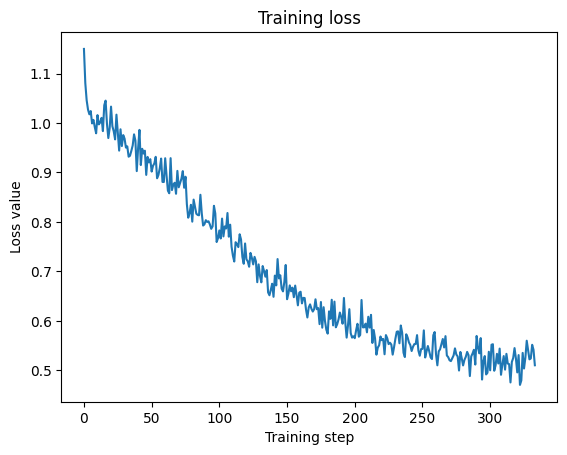

In [ ]:
plt.title("Training loss")
plt.ylabel('Loss value')
plt.xlabel('Training step')
plt.plot(running_loss)
plt.show()

In [ ]:
eval_steps = [i * EVAL_EVERY_STEPS + 1 for i in range(len(train_accs))]

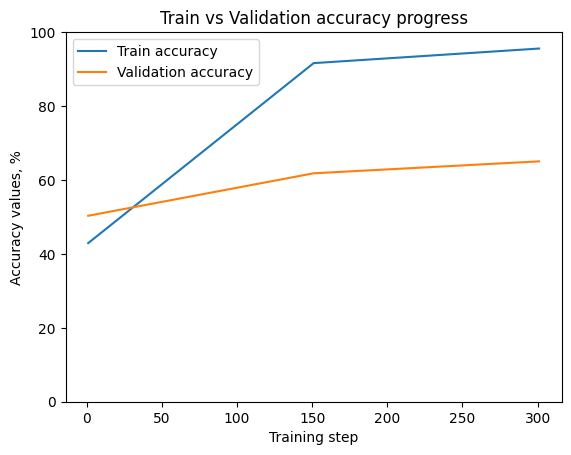

In [ ]:
plt.title('Train vs Validation accuracy progress')
plt.plot(eval_steps, 100*np.array(train_accs), label='Train accuracy')
plt.plot(eval_steps, 100*np.array(val_accs), label='Validation accuracy')
plt.ylabel('Accuracy values, %')
plt.xlabel('Training step')
plt.ylim([0, 100])
plt.legend()
plt.show()

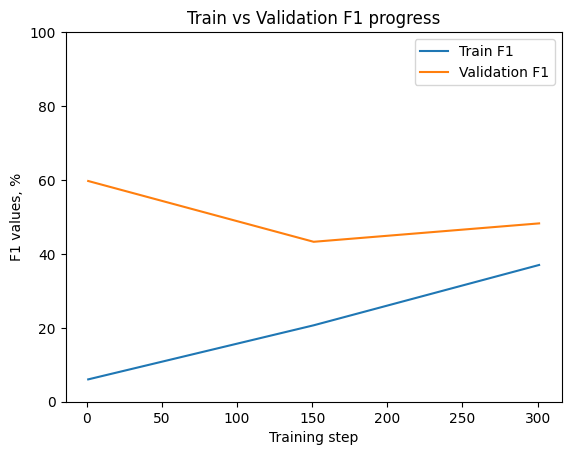

In [ ]:
plt.title('Train vs Validation F1 progress')
plt.plot(eval_steps, 100*np.array(train_f1s), label='Train F1')
plt.plot(eval_steps, 100*np.array(val_f1s), label='Validation F1')
plt.ylabel('F1 values, %')
plt.xlabel('Training step')
plt.ylim([0, 100])
plt.legend()
plt.show()

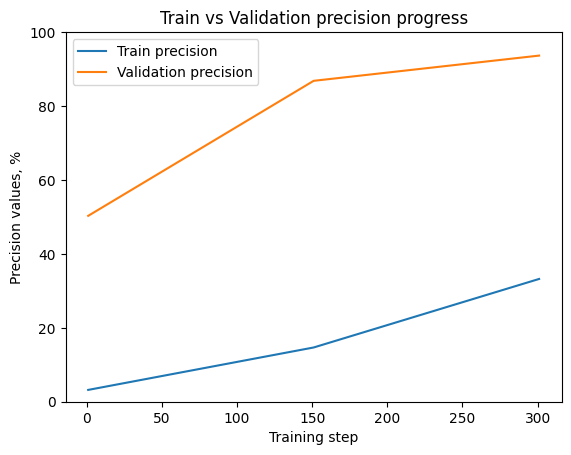

In [ ]:
plt.title('Train vs Validation precision progress')
plt.plot(eval_steps, 100*np.array(train_precs), label='Train precision')
plt.plot(eval_steps, 100*np.array(val_precs), label='Validation precision')
plt.ylabel('Precision values, %')
plt.xlabel('Training step')
plt.ylim([0, 100])
plt.legend()
plt.show()

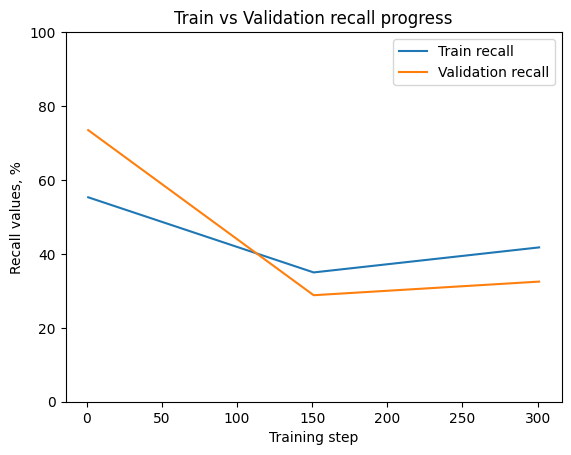

In [ ]:
plt.title('Train vs Validation recall progress')
plt.plot(eval_steps, 100*np.array(train_recs), label='Train recall')
plt.plot(eval_steps, 100*np.array(val_recs), label='Validation recall')
plt.ylabel('Recall values, %')
plt.xlabel('Training step')
plt.ylim([0, 100])
plt.legend()
plt.show()

In [ ]:
# model.eval()
# model_head.eval()

# pred_head = (out_head >= 0).cpu().detach().numpy()
# concatenated_labels = concatenated_labels.cpu().detach().numpy()

# train_acc = accuracy_score(concatenated_labels, pred_head)
# train_prec = precision_score(concatenated_labels, pred_head, zero_division=0)
# train_rec = recall_score(concatenated_labels, pred_head, zero_division=0)
# train_f1 = f1_score(concatenated_labels, pred_head, zero_division=0)

# with torch.no_grad():
#     pred_list = []
#     labels_list = []
#     for val_step, (anchor_audio, rel_audio, labels) in enumerate(val_loader):
#         anchor_audio = anchor_audio.to(DEVICE)
#         rel_audio = rel_audio.to(DEVICE)
        
#         optimizer.zero_grad()
#         anchor_out = model(anchor_audio)
#         rel_out = model(rel_audio)

#         labels_list.append(labels.cpu().numpy())

#         concatenated_pairs = torch.cat((anchor_out, rel_out), dim=-1)
#         out_head = model_head(concatenated_pairs)

#         pred_list.append((out_head >= 0).cpu().numpy())
    
#     preds = np.concatenate(pred_list)
#     labels = np.concatenate(labels_list)
#     val_acc = accuracy_score(labels, preds)
#     val_prec = precision_score(labels, preds, zero_division=0)
#     val_rec = recall_score(labels, preds, zero_division=0)
#     val_f1 = f1_score(labels, preds, zero_division=0)

# model.train()
# model_head.train()

# print(f"Step: {step+1} - Triplet Loss: {running_loss[-1]:.4f}, CE Loss: {loss_head:.4f}")
# print(f"\tTrain Acc: {train_acc:.4f}, Train precision: {train_prec:.4f}, Train recall: {train_rec:.4f}, Train F1: {train_f1:.4f}")
# print(f"\tVal Acc: {val_acc:.4f}, Val precision: {val_prec:.4f}, Val recall: {val_rec:.4f}, Val F1: {val_f1:.4f}")

# if val_f1 > best_val_f1:
#     best_val_f1 = val_f1
#     torch.save(model.state_dict(), MODEL_SAVE_PATH)
#     torch.save(model_head.state_dict(), MODEL_HEAD_SAVE_PATH)
#     print('\tSaving the model...')

# Testing saved model (Inference)

In [ ]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model_head.load_state_dict(torch.load(MODEL_HEAD_SAVE_PATH))

<All keys matched successfully>

In [ ]:
model.eval()
model_head.eval()

SiameseHead(
  (dropout): Dropout(p=0.25, inplace=False)
  (layers): Sequential(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=128, out_features=32, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.25, inplace=False)
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
labels = []
probas = []
with torch.no_grad():
    for audio_1, audio_2, sr, label, _, _ in tqdm(test_dataset):
        audio_1 = audio_1.to(DEVICE).unsqueeze(0)
        audio_2 = audio_2.to(DEVICE).unsqueeze(0)
        out_1 = model(audio_1)
        out_2 = model(audio_2)
        out_proba1 = torch.sigmoid(model_head(torch.cat((out_1, out_2), dim=-1)))
        out_proba2 = torch.sigmoid(model_head(torch.cat((out_2, out_1), dim=-1)))
        labels.append(label)
        probas.append(((out_proba1 + out_proba2)/2).cpu().numpy())

  0%|          | 10/37720 [00:00<22:28, 27.96it/s]

100%|██████████| 37720/37720 [13:14<00:00, 47.47it/s]


In [ ]:
y_pred = np.concatenate(probas)
y_true = np.array(labels)

## Test metrics

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_pred.reshape((-1)))

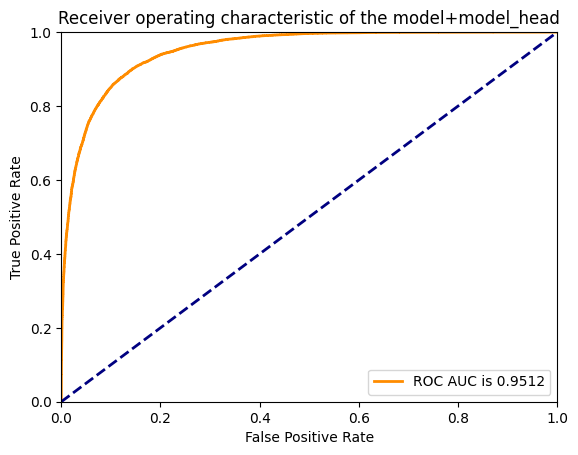

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    label=f'ROC AUC is {roc_auc_score(y_true, y_pred.reshape((-1))):.4f}',
    lw=lw
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic of the model+model_head")
plt.legend(loc="lower right")
plt.show()

In [ ]:
THRESH = 0.5

In [ ]:
accuracy_score(y_true, y_pred >= THRESH)

0.7945387062566278

In [ ]:
f1_score(y_true, y_pred >= THRESH), precision_score(y_true, y_pred >= THRESH), recall_score(y_true, y_pred >= THRESH)

(0.7497255053930116, 0.9588633735337849, 0.6154825026511135)

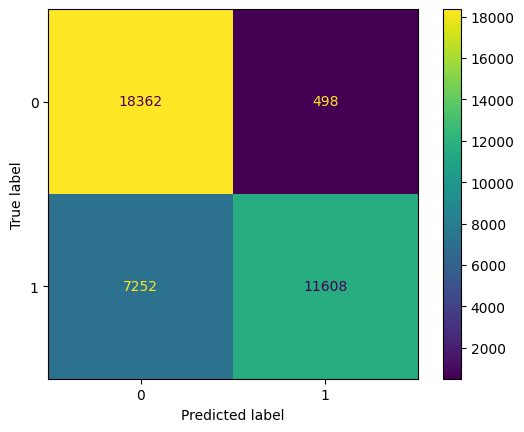

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred >= THRESH))
disp.plot()
plt.show()

Clearing GPUs

In [53]:
del model
del model_head

In [54]:
gc.collect()
empty_cache()

Add:
- [x] Checkpoints
- [x] Augmentations
- [?] Use better models
- [x] Online triplet loss